In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Untitled folder/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


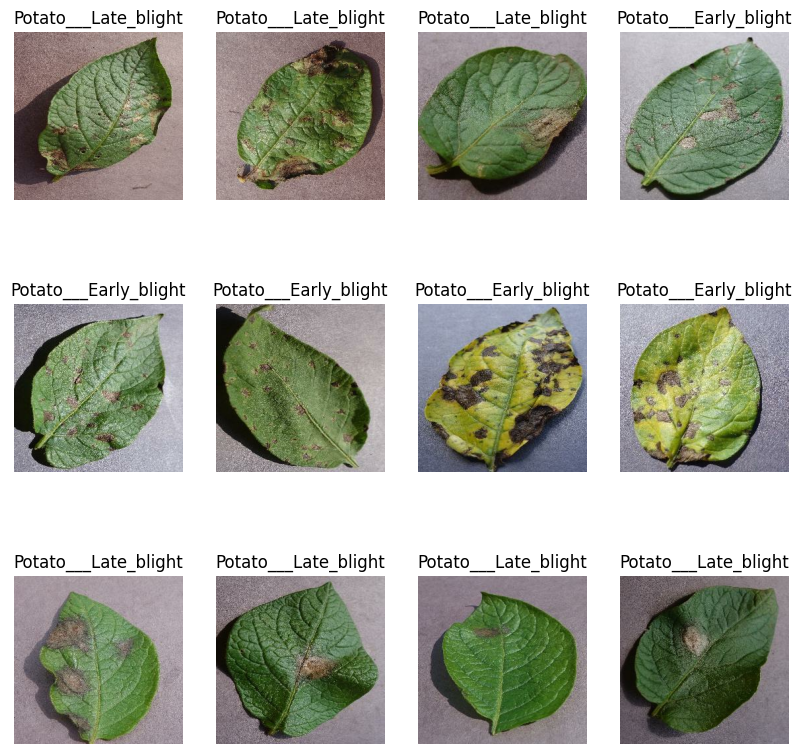

In [5]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
train_size= 0.8
len(dataset)*train_size

54.400000000000006

In [7]:
train_ds = dataset.take(54)
len(train_ds)

54

In [8]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [9]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [10]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [11]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
from tensorflow.keras import models, layers
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
from tensorflow.keras.applications import EfficientNetB0
EfficientNet = EfficientNetB0(input_shape=[256,256] + [3], weights='imagenet', include_top=False)

16705208/16705208 [==============================] - 1s 0us/step


In [22]:
EfficientNet.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [23]:
from glob import glob
folders = glob('/content/drive/MyDrive/Untitled folder/PlantVillage/*')
print(len(folders))

3


In [24]:
for layer in EfficientNet.layers:
  layer.trainable = False

In [25]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

x = Flatten()(EfficientNet.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=EfficientNet.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']      

In [26]:
from keras import optimizers


adam = optimizers.Adam()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=adam,
              metrics=['accuracy'])

In [27]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='mymodel.h5',
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=10,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10


<ipython-input-27-a51e9723ed00>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history=model.fit_generator(


54/54 [==============================] - 296s 195ms/step - loss: 0.7168 - accuracy: 0.9230 - val_loss: 0.0129 - val_accuracy: 0.9948
Epoch 2/10
54/54 [==============================] - 5s 85ms/step - loss: 0.0710 - accuracy: 0.9873 - val_loss: 7.9334e-04 - val_accuracy: 1.0000
Epoch 3/10
54/54 [==============================] - 5s 86ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.0147 - val_accuracy: 0.9948
Epoch 4/10
54/54 [==============================] - 5s 85ms/step - loss: 0.0209 - accuracy: 0.9942 - val_loss: 1.0231e-04 - val_accuracy: 1.0000
Epoch 5/10
54/54 [==============================] - 5s 89ms/step - loss: 0.0119 - accuracy: 0.9965 - val_loss: 0.0340 - val_accuracy: 0.9896
Epoch 6/10
54/54 [==============================] - 5s 86ms/step - loss: 0.0055 - accuracy: 0.9988 - val_loss: 4.8299e-05 - val_accuracy: 1.0000
Epoch 7/10
54/54 [==============================] - 5s 85ms/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 8/1

In [28]:
scores= model.evaluate(test_ds)

8/8 [==============================] - 4s 80ms/step - loss: 0.2226 - accuracy: 0.9805


In [29]:
scores

[0.22257938981056213, 0.98046875]

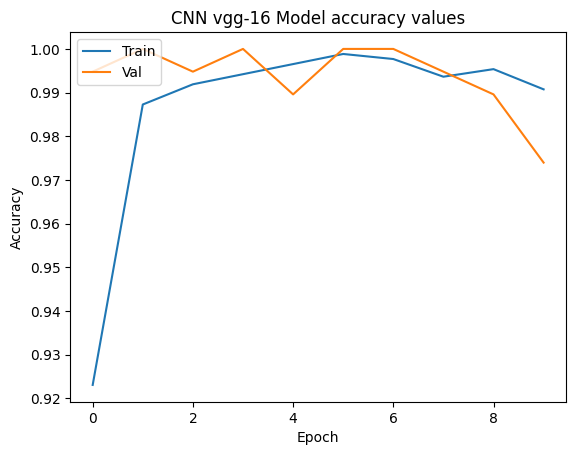

In [30]:
# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN vgg-16 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

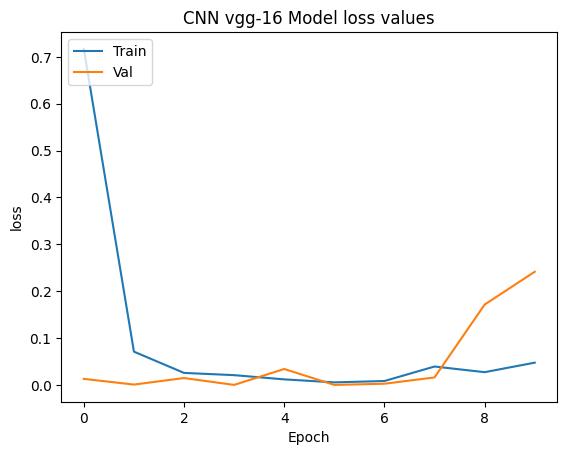

In [31]:
# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('CNN vgg-16 Model loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


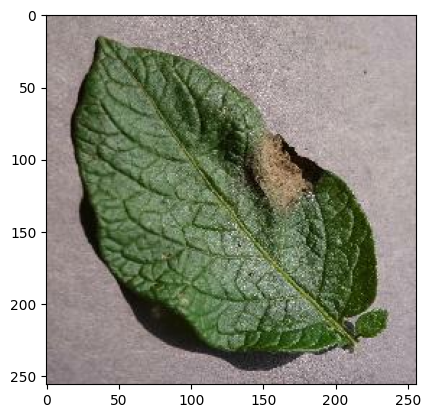

In [32]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


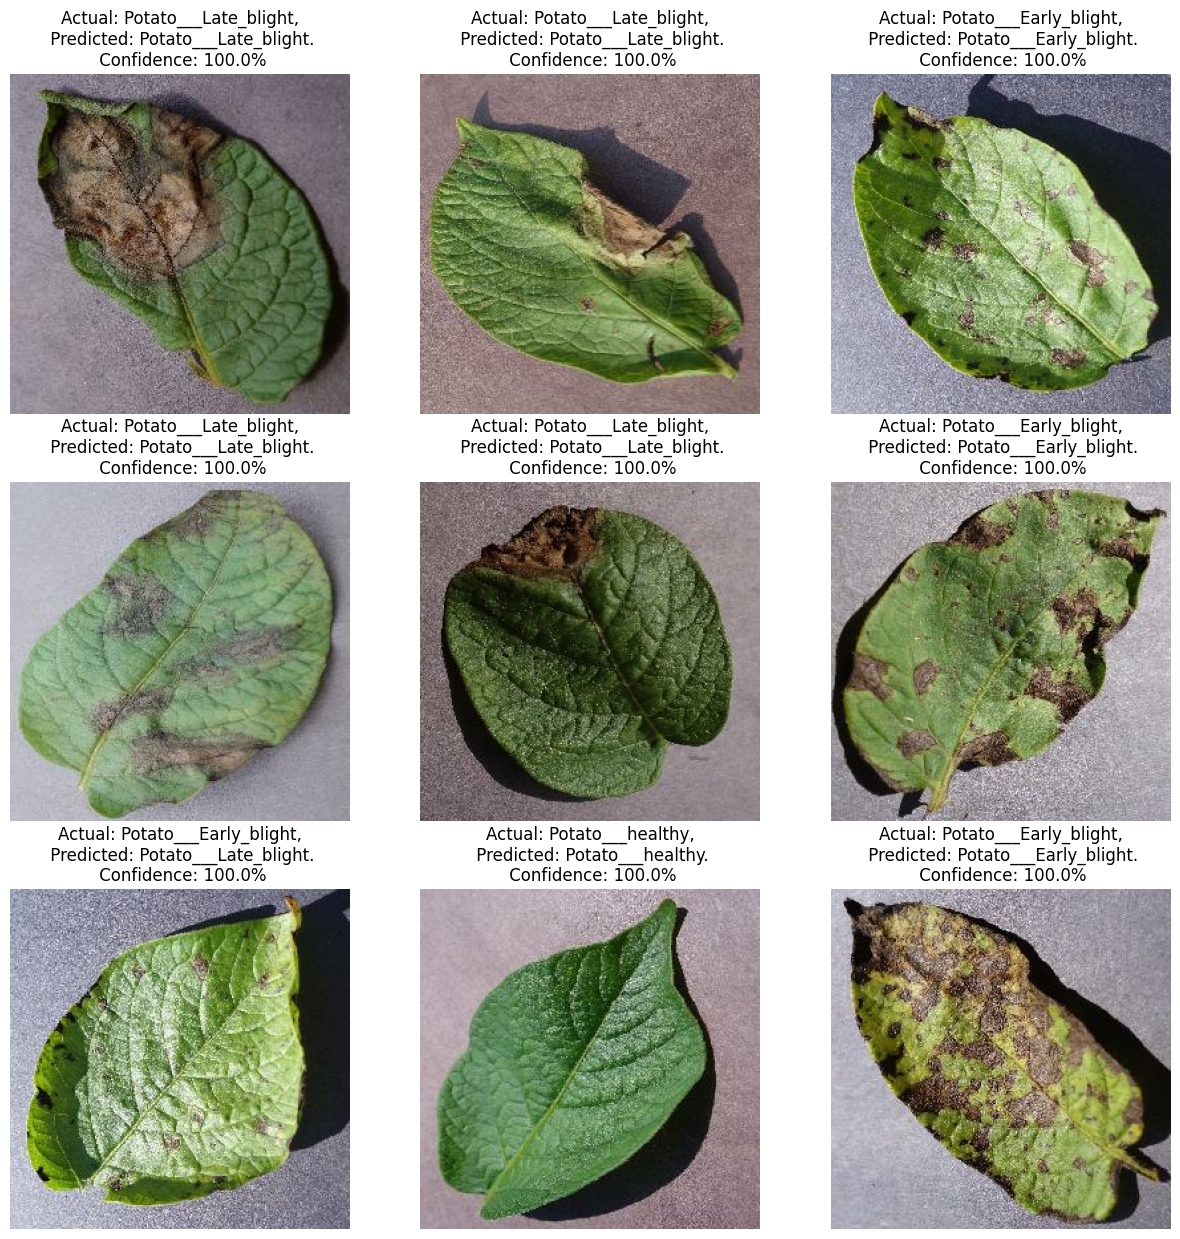

In [34]:
plt.figure(figsize=(15, 15))
image_count = 0
for images, labels in val_ds.take(1):
    for i in range(9):
        if image_count >= len(images):
            break

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[image_count].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[image_count].numpy())
        actual_class = class_names[labels[image_count]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

        image_count += 1
